In [1]:
import numpy as np
import pandas as pd
import pickle
import re
from tqdm.notebook import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint

### Creating Image Features using VGG16

In [3]:
model = VGG16()
model = Model(inputs = model.input, outputs = model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
features = {}
directory = 'dataset/Images'

# Run below code only once and save the features.pkl

# for img_name in tqdm(os.listdir(directory)):
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     image = img_to_array(image)
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     image = preprocess_input(image)
#     feature = model.predict(image, verbose=0)
#     image_id = img_name.split('.')[0]
#     features[image_id] = feature

# pickle.dump(features, open('features.pkl', 'wb'))

In [5]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [6]:
len(features)

31783

### Reading the Dataset

In [7]:
caption_ds = pd.read_csv('dataset/results.csv', sep='|', usecols = [0, 2])
caption_ds.head()

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [8]:
caption_ds.shape

(158915, 2)

In [9]:
caption_ds.sample(6)

,image_name,comment
44787,2826769554.jpg,The dog is running along the beach next to th...
145865,6838340009.jpg,"A man , wearing a black shirt and red lanyard..."
120597,4837825680.jpg,A rollerblader is skating against the flow of...
101701,4503611071.jpg,A young man is performing a stunt on his BMX ...
99714,4452980085.jpg,A Chinese store in a shopping plaza .
59530,3186694070.jpg,The guy with a green long-sleeved shirt is in...


In [10]:
caption_ds.columns

Index(['image_name', ' comment'], dtype='object')

In [11]:
caption_ds.isna().sum()

image_name    0
 comment      1
dtype: int64

In [12]:
list(caption_ds[caption_ds['image_name']=='2199200615.jpg'].iloc[:, 1])

[' A dog running on green grass with its mouth open and tongue hanging out .',
 ' a white dog is running with its mouth open across the grass .',
 ' A white , black , and brown dog runs in a field .',
 ' A dog runs across the grassy field .',
 nan]

(-0.5, 223.5, 223.5, -0.5)

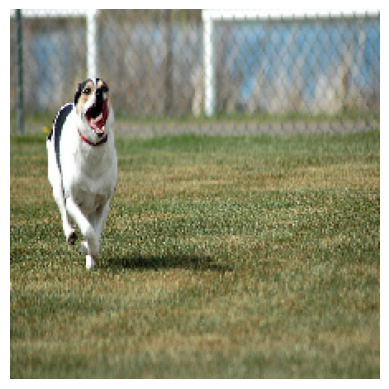

In [13]:
image = load_img(directory + '/2199200615.jpg', target_size=(224, 224))
plt.imshow(image)
plt.axis('off')

In [14]:
caption_ds.fillna('A white and black dog is running across grassy field with its mouth open', inplace = True)

In [15]:
caption_grp = caption_ds.groupby('image_name')
caption_grp.get_group('3421104520.jpg')

,image_name,comment
69965,3421104520.jpg,Two young girls are playing with plastic ball...
69966,3421104520.jpg,Two young girls are in an enclosure filled wi...
69967,3421104520.jpg,Two small girls playing in a multicolored bal...
69968,3421104520.jpg,Two little children are in a bin of colored b...
69969,3421104520.jpg,Kids playing in a tub of plastic balls .


In [16]:
mapping = caption_grp[' comment'].apply(list).to_dict()
len(mapping)

31783

In [17]:
list(mapping.items())[:2]

[('1000092795.jpg',
  [' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
   ' Two young , White males are outside near many bushes .',
   ' Two men in green shirts are standing in a yard .',
   ' A man in a blue shirt standing in a garden .',
   ' Two friends enjoy time spent together .']),
 ('10002456.jpg',
  [' Several men in hard hats are operating a giant pulley system .',
   ' Workers look down from up above on a piece of equipment .',
   ' Two men working on a machine wearing hard hats .',
   ' Four men on top of a tall structure .',
   ' Three men on a large rig .'])]

### Caption Preprocessing

In [18]:
def caption_preprocessing(mapping):
    for img_id, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub('[^A-Za-z ]', '', caption)
            caption = re.sub(' +', ' ', caption)
            caption = 'startseq' + caption + 'endseq'
            captions[i] = caption

In [19]:
mapping['3421104520.jpg']

[' Two young girls are playing with plastic balls in a ball pit .',
 ' Two young girls are in an enclosure filled with balls .',
 ' Two small girls playing in a multicolored ball pen .',
 ' Two little children are in a bin of colored balls .',
 ' Kids playing in a tub of plastic balls .']

In [20]:
caption_preprocessing(mapping)

In [21]:
mapping['3421104520.jpg']

['startseq two young girls are playing with plastic balls in a ball pit endseq',
 'startseq two young girls are in an enclosure filled with balls endseq',
 'startseq two small girls playing in a multicolored ball pen endseq',
 'startseq two little children are in a bin of colored balls endseq',
 'startseq kids playing in a tub of plastic balls endseq']

In [22]:
all_caption = []
for img_name, captions in mapping.items():
    for caption in captions:
        all_caption.append(caption)
len(all_caption)

158915

In [23]:
all_caption[52:57]

['startseq five girls are leaping simultaneously in a dance practice room endseq',
 'startseq five girls dancing and bending feet in ballet class endseq',
 'startseq a ballet class of five girls jumping in sequence endseq',
 'startseq three young men and a young woman wearing sneakers are leaping in midair at the top of a flight of concrete stairs endseq',
 'startseq four casually dressed guys jumping down a stairway outdoors with a stone wall behind them endseq']

### Tokenization

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size = len(tokenizer.word_index) + 1

In [25]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [26]:
vocab_size 

21524

In [27]:
max_length = max(len(caption.split()) for caption in all_caption)
max_length

80

### Train Test Split

In [28]:
image_name = list(mapping.keys())
split = int(len(image_name)*0.8)
train = image_name[:split]
test = image_name[split:]

In [29]:
print(len(train))
print(len(test))

25426
6357


In [30]:
# data generator for batch training

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(caption.split())):
                               in_seq, out_seq = seq[:i], seq[i]
                               in_seq = pad_sequences([in_seq], max_length)[0]
                               out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                               ind_x = key.split('.')[0]
                               X1.append(features[ind_x][0])
                               X2.append(in_seq)
                               y.append(out_seq)
                if n==batch_size:
                               X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                               yield [X1, X2], y
                               X1, X2, y = [], [], []
                               n = 0

### Model Building

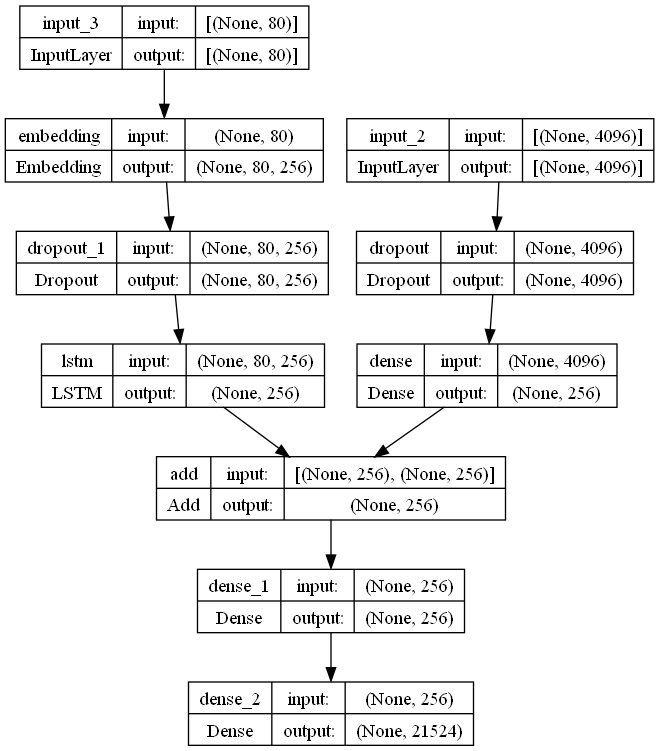

In [31]:
# encoder
# image features
inputs1 = Input(shape = (4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# seq feature layer
inputs2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 256)      5510144     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

### Model Training

In [33]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

filepath = 'models/model-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq='epoch')
callback_list = [checkpoint]

In [34]:
for i in range(10):
    print('Epoch:\t', i+1)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=callback_list)

Epoch:	 1
794/794 [==============================] - ETA: 0s - loss: 4.2729
Epoch 1: saving model to models\model-01.h5
794/794 [==============================] - 258s 320ms/step - loss: 4.2729
Epoch:	 2
794/794 [==============================] - ETA: 0s - loss: 3.4156
Epoch 1: saving model to models\model-01.h5
794/794 [==============================] - 270s 340ms/step - loss: 3.4156
Epoch:	 3
794/794 [==============================] - ETA: 0s - loss: 3.1691
Epoch 1: saving model to models\model-01.h5
794/794 [==============================] - 269s 339ms/step - loss: 3.1691
Epoch:	 4
794/794 [==============================] - ETA: 0s - loss: 3.0108
Epoch 1: saving model to models\model-01.h5
794/794 [==============================] - 272s 343ms/step - loss: 3.0108
Epoch:	 5
794/794 [==============================] - ETA: 0s - loss: 2.8922
Epoch 1: saving model to models\model-01.h5
794/794 [==============================] - 272s 343ms/step - loss: 2.8922
Epoch:	 6
794/794 [===========

In [35]:
model.save('models/final-model-10.h5')

In [36]:
model = load_model('models/final-model-10.h5')

In [37]:
filepath = '/models/model_1020-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq='epoch')
callback_list = [checkpoint]

for i in range(10, 20):
    print('Epoch:\t', i+1)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=callback_list)

Epoch:	 11
794/794 [==============================] - ETA: 0s - loss: 2.5550
Epoch 1: saving model to /models\model_1020-01.h5
794/794 [==============================] - 288s 360ms/step - loss: 2.5550
Epoch:	 12
794/794 [==============================] - ETA: 0s - loss: 2.5263
Epoch 1: saving model to /models\model_1020-01.h5
794/794 [==============================] - 298s 375ms/step - loss: 2.5263
Epoch:	 13
794/794 [==============================] - ETA: 0s - loss: 2.5021
Epoch 1: saving model to /models\model_1020-01.h5
794/794 [==============================] - 299s 376ms/step - loss: 2.5021
Epoch:	 14
794/794 [==============================] - ETA: 0s - loss: 2.4789
Epoch 1: saving model to /models\model_1020-01.h5
794/794 [==============================] - 300s 377ms/step - loss: 2.4789
Epoch:	 15
794/794 [==============================] - ETA: 0s - loss: 2.4586
Epoch 1: saving model to /models\model_1020-01.h5
794/794 [==============================] - 301s 379ms/step - loss: 2.

In [38]:
model.save('models/final_model_1020.h5')

In [36]:
model = load_model('models/final_model_1020.h5')

In [37]:
filepath = 'models/model_2030-{epoch:02d}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_freq='epoch')
callback_list = [checkpoint]

for i in range(20, 30):
    print('Epoch:\t', i+1)
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=callback_list)

Epoch:	 21
794/794 [==============================] - ETA: 0s - loss: 2.3688
Epoch 1: saving model to models\model_2030-01.h5
794/794 [==============================] - 269s 334ms/step - loss: 2.3688
Epoch:	 22
794/794 [==============================] - ETA: 0s - loss: 2.3573
Epoch 1: saving model to models\model_2030-01.h5
794/794 [==============================] - 264s 333ms/step - loss: 2.3573
Epoch:	 23
794/794 [==============================] - ETA: 0s - loss: 2.3459
Epoch 1: saving model to models\model_2030-01.h5
794/794 [==============================] - 269s 339ms/step - loss: 2.3459
Epoch:	 24
794/794 [==============================] - ETA: 0s - loss: 2.3374
Epoch 1: saving model to models\model_2030-01.h5
794/794 [==============================] - 275s 347ms/step - loss: 2.3374
Epoch:	 25
794/794 [==============================] - ETA: 0s - loss: 2.3280
Epoch 1: saving model to models\model_2030-01.h5
794/794 [==============================] - 275s 346ms/step - loss: 2.3280


In [34]:
model.save('models/final_model_2030.h5')

In [34]:
model = load_model('models/model_2030-01.h5')

### Generating Captions

In [35]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
# Caption Prediction
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

### Score

In [37]:
import random

random.shuffle(test)
selected_keys = test[:len(test) // 2]

actual, predicted = [], []

for key in tqdm(selected_keys):
    ind_x = key.split('.')[0]
    captions = mapping[key]
    y_pred = predict_caption(model, features[ind_x], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/3178 [00:00<?, ?it/s]

In [43]:
print("BLEU-1: %f" % corpus_bleu(actual[:3178], predicted[:3178], weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual[:3178], predicted[:3178], weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.623424
BLEU-2: 0.412801


In [48]:
# generating image from train dataset
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory+'/', image_name)
    image = Image.open(img_path)
    captions = mapping[image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq a biker demonstrates his talents in the air by placing only his left arm on the bike seat endseq
startseq a motocross rider performs a trick in the air at a stadium as the sun sets endseq
startseq dirt bike racer in the air with one hand on the dirt bike and body in air endseq
startseq a professional motocross rider is performing a midair stunt on his bike endseq
startseq a stuntman jumping a motorcycle in a stadium endseq
--------------------Predicted--------------------
startseq a man is riding a bicycle on a tightrope endseq


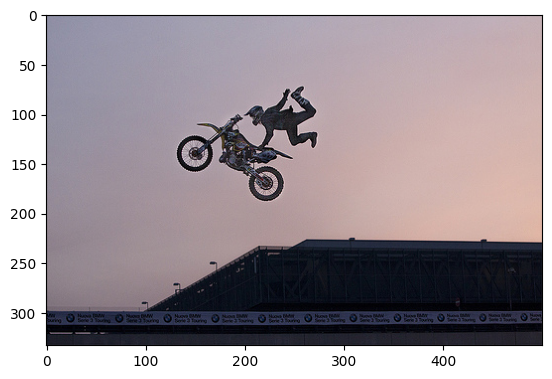

In [54]:
generate_caption('8212843678.jpg')

---------------------Actual---------------------
startseq a man is singing on stage wearing a white shirt and a black vest and black pants while holding a guitar endseq
startseq an older gentleman wearing a white shirt and black vest is playing a guitar while singing endseq
startseq a man in a black vest is playing a guitar and another man playing a guitar beside him endseq
startseq a balding man is playing guitar and singing endseq
startseq a band of older men perform live on stage endseq
--------------------Predicted--------------------
startseq a man in a suit is playing a guitar endseq


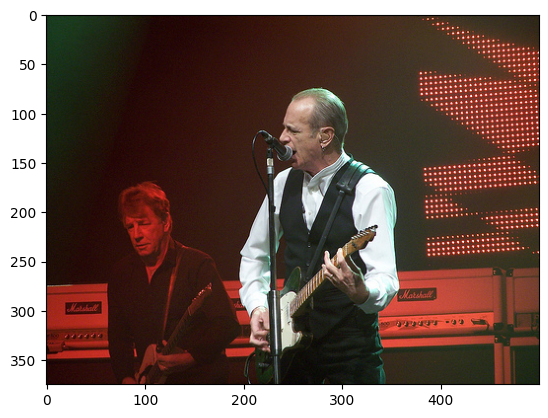

In [55]:
generate_caption('8204629082.jpg')

---------------------Actual---------------------
startseq a woman in black bicycle gear and a white helmet pedals hard uphill on her bike endseq
startseq a cyclist wearing sunglasses and a silver bicycle helmet competing in a race endseq
startseq a woman wearing red and black biking gear biking up a hill endseq
startseq a bike racer following the racing trail uphill endseq
startseq a woman cycling up a hill endseq
--------------------Predicted--------------------
startseq a man in a blue shirt is riding a bike endseq


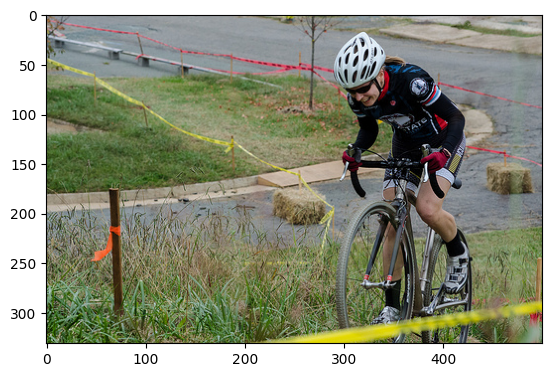

In [57]:
generate_caption('8131954252.jpg')

---------------------Actual---------------------
startseq two men one africanamerican and one white play acoustic guitars and sing into microphones in an outdoor setting endseq
startseq two men are singing and playing guitars outside a cement structure with spectators sitting on steps on their left endseq
startseq two men one black and one white play their guitars and sing into microphones as they stand outdoors endseq
startseq a black man and a white man with acoustic guitars are standing in front of microphones endseq
startseq two males one white and one black singing and playing the guitar endseq
--------------------Predicted--------------------
startseq a man in a black shirt plays a guitar endseq


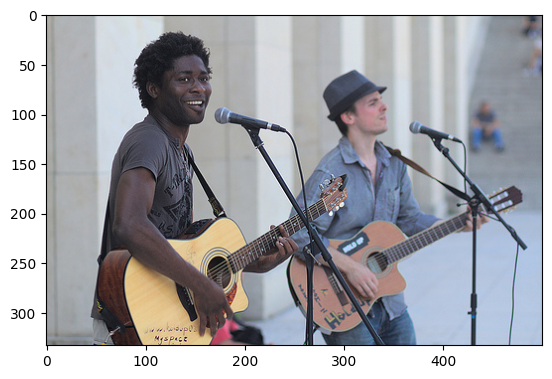

In [58]:
generate_caption('7983388093.jpg')

---------------------Actual---------------------
startseq an asian woman with glasses intently works on her laptop at a desk of a business endseq
startseq a woman is working on a laptop at her desk with a notebook and water bottle endseq
startseq a lady with a yellow blouse and glasses at a desk with a laptop computer endseq
startseq a woman with glasses and a flower on her shirt is typing on her laptop endseq
startseq a woman in a yellow shirt sits at her desk and uses her laptop endseq
--------------------Predicted--------------------
startseq a man in a black shirt is sitting at a desk with a laptop endseq


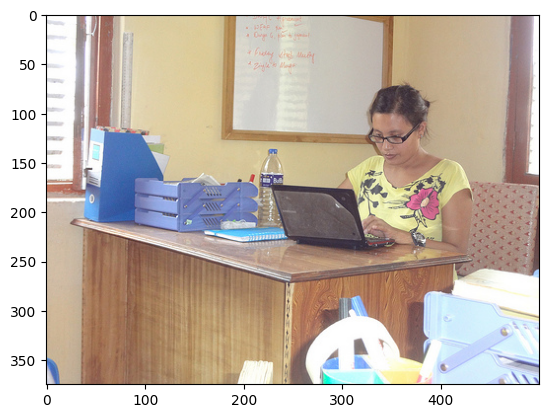

In [61]:
generate_caption('7666764962.jpg')

### Images outside dataset

In [65]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

startseq a woman in a black shirt and sunglasses is taking a picture endseq


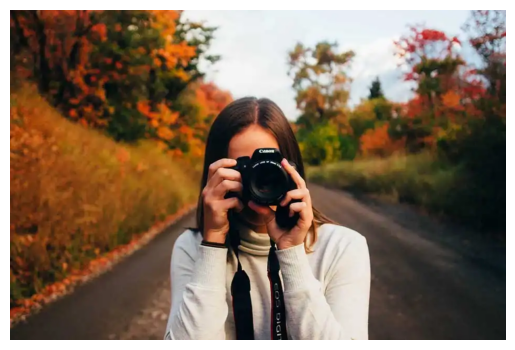

In [85]:
image_path = 'Images from internet/2.jpg'

image = load_img(image_path, target_size=(224, 224))

image = img_to_array(image)

image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

image = preprocess_input(image)

feature = vgg_model.predict(image, verbose=0)

print(predict_caption(model, feature, tokenizer, max_length))

jpeg_image = Image.open(image_path)

plt.imshow(jpeg_image)
plt.axis('off') 
plt.show()